In [1]:
import matplotlib.pyplot as plt
from gsmmutils import MyModel
import seaborn as sns
from tqdm import tqdm
sns.set(rc={'figure.figsize':(35,8.27)})
DATA_PATH = r"../data"
from os.path import join
from cobra.flux_analysis import pfba, flux_variability_analysis as fva
from utils.utils import get_ps_params_multi, evaluate_light_sources

In [2]:
ds = MyModel(join(DATA_PATH, 'models/model_ds.xml'), 'e_Biomass__cytop')
ds.set_prism_reaction("PRISM_solar_litho__extr")
ds.exchanges.EX_C00205__dra.bounds = (-20000, 20000)
print(ds.slim_optimize())
ng = MyModel(join(DATA_PATH, 'models/model_ng.xml'), 'e_Biomass__cytop')
ng.exchanges.EX_C00205__dra.bounds = (-20000, 20000)
ng.set_prism_reaction("PRISM_solar_litho__extr")
print(ng.slim_optimize())
pl = MyModel(join(DATA_PATH, 'models/model_pl.xml'), 'e_Biomass__cytop')
pl.exchanges.EX_C00205__dra.bounds = (-20000, 20000)
pl.set_prism_reaction("PRISM_fluorescent_cool_215W__extr")
pl.reactions.e_Biomass_ht__cytop.bounds = (0,0)
print(pl.slim_optimize())

Loading

Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-15
Reactions: 4515
Metabolites: 3680
Genes: 1700
Model loaded
0.20060897294144756
Loading

Reactions: 4437
Metabolites: 3771
Genes: 1333
Model loaded
0.40715632401484175
Loading

Reactions: 4714
Metabolites: 4173
Genes: 1349
Model loaded
0.17297410371385694


In [3]:
get_ps_params_multi({"Dsalina": ds, "Ngadiitana": ng, "Plutheri": pl})

,QY,PQ
Dsalina,0.037,1.243
Ngadiitana,0.032,1.409
Plutheri,0.028,1.416


In [678]:
results = evaluate_light_sources(ds)
sns.barplot(x=list(key.split("__")[0] for key in results.keys()), y=list(results.values()), hue=list(key.split("__")[0] for key in results.keys()), palette="viridis")
plt.ylabel('Light uptake (mmol gDW^-1 d^-1)')

KeyError: <Reaction PRISM_solar_litho__extr at 0x2741e261c00>

In [ ]:
results = evaluate_light_sources(ng)
sns.barplot(x=list(key.split("__")[0] for key in results.keys()), y=list(results.values()), hue=list(key.split("__")[0] for key in results.keys()), palette="viridis")
plt.ylabel('Light uptake (mmol gDW^-1 d^-1)')

In [ ]:
results = evaluate_light_sources(pl)
sns.barplot(x=list(key.split("__")[0] for key in results.keys()), y=list(results.values()), hue=list(key.split("__")[0] for key in results.keys()), palette="viridis")
plt.ylabel('Light uptake (mmol gDW^-1 d^-1)')

In [43]:
fva(pl, ["STCHLc2PSII__chlo"], fraction_of_optimum=0.9)

,minimum,maximum
STCHLc2PSII__chlo,1.88529,4.317616


In [41]:
pl.test_reaction("STCHLc2PSII__chlo")

,Flux,ReactantOrProduct
Chlorophyll a,0.193074,Reactant
"Photosystem II excited chlorophyll C2, Qy band (long wavelength)",0.302534,Reactant
chlorophyll c2,0.001133,Product
"Photosystem II excited chlorophyll A, Qy band (long wavelength)",0.003864,Product


In [6]:
with ng as tmp:
    tmp.exchanges.EX_C00205__dra.bounds = (-2100, -2100)
    ngam = 2100/1.49*0.022+6.85
    tmp.reactions.NGAM__lum.bounds = (ngam, ngam)
    print(tmp.summary())

Running pFBA
Objective
1.0 e_Biomass__cytop = 0.4071563240148421

Uptake
------
  Metabolite       Reaction      Flux  C-Number C-Flux
C00001__extr EX_C00001__dra     14.52         0  0.00%
C00009__extr EX_C00009__dra   0.07453         0  0.00%
C00011__extr EX_C00011__dra     19.49         1 99.91%
C00059__extr EX_C00059__dra   0.06003         0  0.00%
C00080__extr EX_C00080__dra     2.442         0  0.00%
C00120__extr EX_C00120__dra 0.0006624        10  0.03%
C00205__extr EX_C00205__dra      2100         0  0.00%
C00244__extr EX_C00244__dra     1.794         0  0.00%
C00305__extr EX_C00305__dra  0.006568         0  0.00%
C00378__extr EX_C00378__dra 0.0003807        12  0.02%
C02823__extr EX_C02823__dra  0.000102        63  0.03%
C06232__extr EX_C06232__dra 0.0003104         0  0.00%
C14818__extr EX_C14818__dra  0.002096         0  0.00%

Secretion
---------
      Metabolite            Reaction      Flux  C-Number  C-Flux
  pho_loss__chlo   DM_pho_loss__chlo    -936.3         0   0.00%

In [6]:
from light_absorption import update_model
def get_npq(origin_model, coeff, conversion_factor, organism):
    origin_model.reactions.PSII__lum.bounds = (0, 199.5)
    with origin_model as tmp:
        old_co2 = pfba(tmp).fluxes["EX_C00011__dra"]
        tmp.exchanges.EX_C00205__dra.bounds = (-5000, 5000)
        tmp.objective = "EX_C00205__dra"
        tmp.objective_direction = "max"
        min_val = tmp.slim_optimize()
        tmp.objective_direction = "min"
        max_val = 2000
    origin_model.exchanges.EX_C00011__dra.lower_bound = old_co2
    npq = {}
    uptake =  range(int(round(abs(min_val),0)), int(round(abs(max_val),0)), 200)
    for i in tqdm(uptake):
        with origin_model as tmp:
            model = update_model(tmp, organism, i)
            model.exchanges.EX_C00205__dra.bounds = (-i, -i)
            ngam = origin_model.exchanges.EX_C00205__dra.lower_bound /conversion_factor*0.022+6.85
            model.reactions.NGAM__lum.bounds = (ngam, ngam)
            # model.reactions.ATPm__cytop.bounds = (0,0)
            sol = model.maximize(value=False)
            if  not isinstance(sol, int):
                # print(sol.fluxes['PSIICR__lum'] / abs(sol.fluxes['EX_C00205__dra']))
                heat = abs(sol.fluxes['DM_pho_loss__chlo']) 
                flv = abs(sol.fluxes['FLV__chlo']) if 'FLV__chlo' in sol.fluxes else 0
                cef = abs(sol.fluxes['CEF__chlo']) if 'CEF__chlo' in sol.fluxes else abs(sol.fluxes['CEF_2__chlo'])
                d1 = abs(sol.fluxes['NGAM_D1__chlo']) * 1000
                thioredoxin = abs(sol.fluxes['R12570__chlo']) if 'R12570__chlo' in sol.fluxes else 0
                ascorbate = abs(sol.fluxes['R09540__chlo']) if 'R09540__chlo' in sol.fluxes else 0
                glutathione = abs(sol.fluxes['R00274__chlo']) if 'R00274__chlo' in sol.fluxes else 0
                cytochrome = abs(sol.fluxes['R00017__mito']) if 'R00017__mito' in sol.fluxes else 0
                ros = flv+cef+d1 + ascorbate + glutathione + cytochrome + thioredoxin
                npq[i/conversion_factor] = ((heat + ros) /(abs(sol.fluxes['EX_C00205__dra'])*coeff), (heat) /(abs(sol.fluxes['EX_C00205__dra'])*coeff), (ros) /(abs(sol.fluxes['EX_C00205__dra'])*coeff), (flv) /(abs(sol.fluxes['EX_C00205__dra'])*coeff), (cef) /(abs(sol.fluxes['EX_C00205__dra'])*coeff), (d1) /(abs(sol.fluxes['EX_C00205__dra'])*coeff), (ascorbate) /(abs(sol.fluxes['EX_C00205__dra'])*coeff), glutathione / (abs(sol.fluxes['EX_C00205__dra']) * coeff),  cytochrome / (abs(sol.fluxes['EX_C00205__dra']) * coeff), thioredoxin / (abs(sol.fluxes['EX_C00205__dra']) * coeff),  sol.fluxes["e_Biomass__cytop"])
    # create fig with two plots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    # round all npq keys to 0 decimal places
    # round values to 3 decimal places
    sns.lineplot(x=list(npq.keys()), y=[v[0] for v in npq.values()], label="Total NPQ", ax=ax1) #
    sns.lineplot(x=list(npq.keys()), y=[v[1] for v in npq.values()], label="Heat NPQ", ax=ax1)
    sns.lineplot(x=list(npq.keys()), y=[v[2] for v in npq.values()], label="ROS NPQ", ax=ax1)
    if not isinstance(sol, int) and  'FLV__chlo' in sol.fluxes:
        sns.lineplot(x=list(npq.keys()), y=[v[3] for v in npq.values()], label="FLV NPQ", ax=ax2) 
    sns.lineplot(x=list(npq.keys()), y=[v[4] for v in npq.values()], label="CEF NPQ", ax=ax2) 
    sns.lineplot(x=list(npq.keys()), y=[v[5] for v in npq.values()], label="D1 NPQ", ax=ax2) 
    if   not isinstance(sol, int) and   'R09540__chlo' in sol.fluxes:
        sns.lineplot(x=list(npq.keys()), y=[v[6] for v in npq.values()], label="Ascorbate NPQ", ax=ax2) 
    if  not isinstance(sol, int) and   'R00274__chlo' in sol.fluxes:
        sns.lineplot(x=list(npq.keys()), y=[v[7] for v in npq.values()], label="Glutathione NPQ", ax=ax2) 
    if   not isinstance(sol, int) and  'R00017__mito' in sol.fluxes:
        sns.lineplot(x=list(npq.keys()), y=[v[8] for v in npq.values()], label="Cytochrome NPQ", ax=ax2) 
    if   not isinstance(sol, int) and  'R12570__chlo' in sol.fluxes:
        sns.lineplot(x=list(npq.keys()), y=[v[9] for v in npq.values()], label="Thioredoxin NPQ", ax=ax2) 
    plt.ylabel('NPQ')
    plt.xlabel('Light intensity (uE)')

    # sns.lineplot(x=list(npq.keys()), y=[v[-1] for v in npq.values()], ax=ax2, color='red', label="Growth rate")
    return npq

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


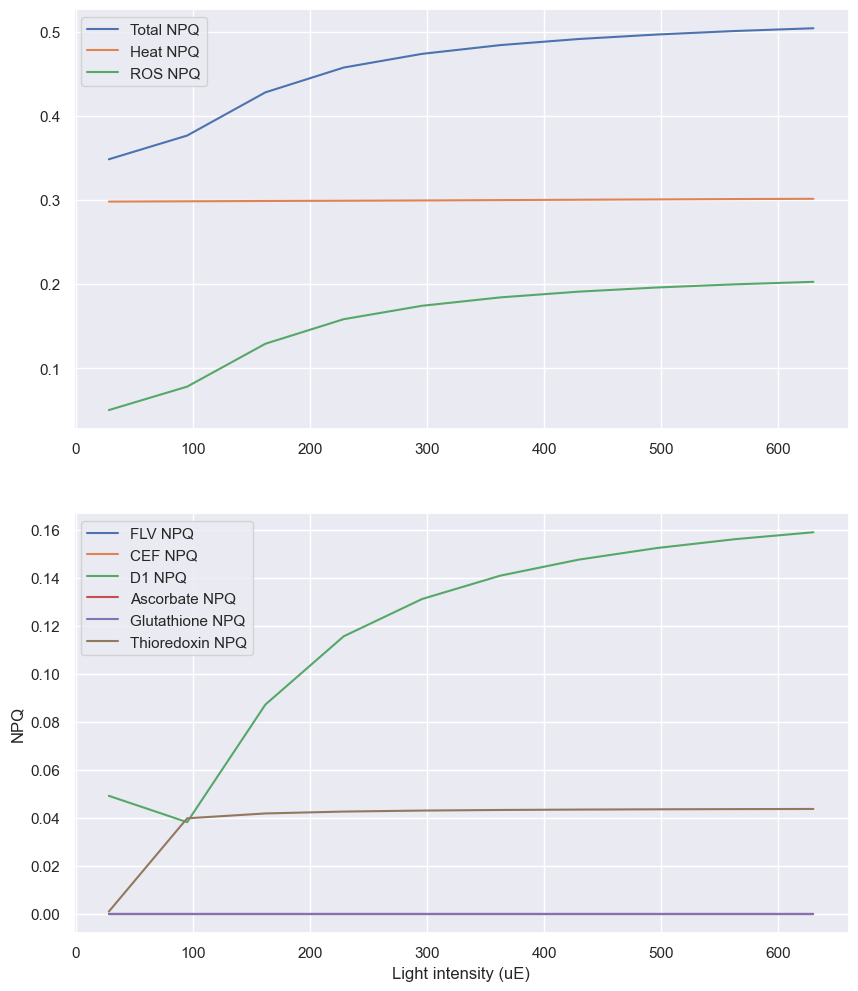

In [7]:
coeff = sum(e for e in ds.reactions.PRISM_solar_litho__extr.metabolites.values() if e > 0)
with ds as tmp:
    get_npq(tmp, coeff, 2.99, "dsalina")

100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


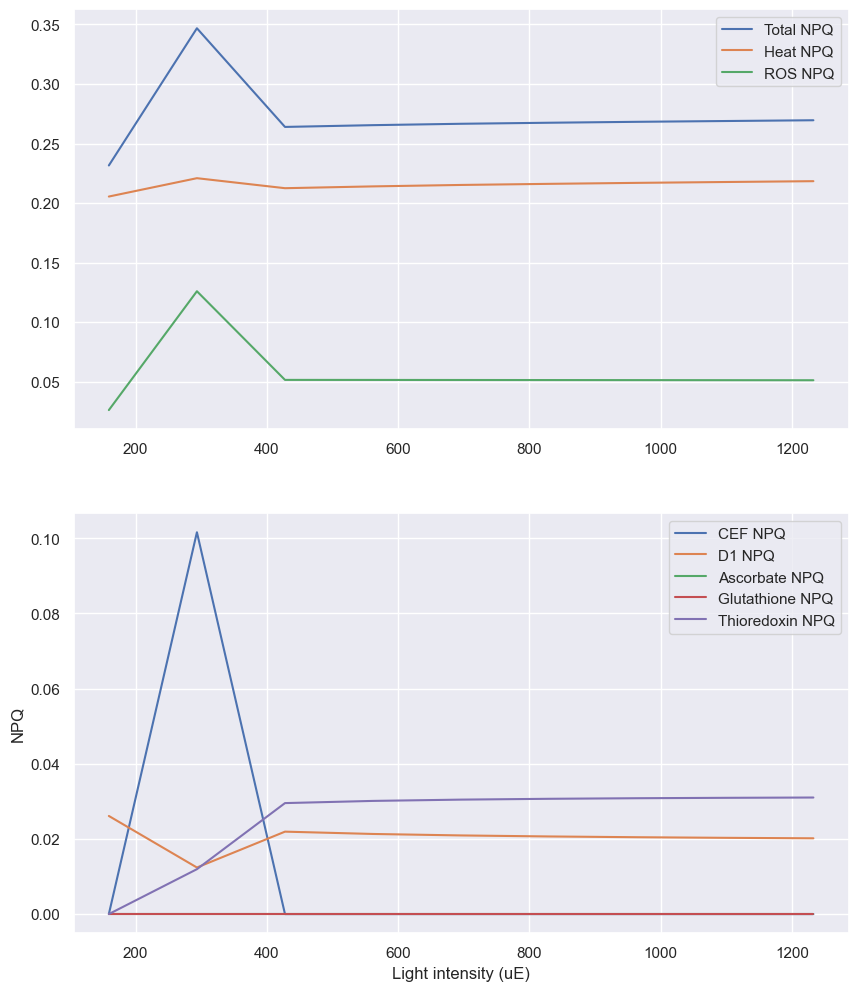

In [18]:
coeff = sum(e for e in ng.reactions.PRISM_solar_litho__extr.metabolites.values() if e > 0)
with ng as tmp:
    get_npq(tmp, coeff, 1.49, "ngaditana")

In [ ]:
coeff = sum(e for e in pl.reactions.PRISM_solar_litho__extr.metabolites.values() if e > 0)
pl.set_prism_reaction("PRISM_solar_litho__extr")
with pl as tmp:
    get_npq(tmp, coeff, 7.6)